# SECTION 1: Data Understanding and Preprocessing
SECTION 1: Data Understanding and Preprocessing (30 pts)
Dataset: You are provided with time-series data of ICU patients including the following:
- Heart Rate (HR)
- Blood Pressure (BP_sys, BP_dia)
- Oxygen Saturation (SpO2)
- Temperature
- Lab values (e.g., WBC, Lactate)
- Demographics
- Timestamped intervention events (e.g., ventilation start, medication given)
Task 1:
Describe how you would handle the following issues in ICU patient data:
1. Missing values
2. Irregular time intervals
3. Anomalies (e.g., sensor dropouts)
4. Outliers caused by temporary disconnections

In [181]:
#import necessary liabriies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [182]:
from google.colab import drive# for google mount
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
Sickbay=pd.read_csv('/content/synthetic_sickbay_dataset.csv')#load the dataset

In [184]:
Sickbay.head()# to get the head of the datset

,patient_id,timestamp_min,heart_rate,bp_sys,bp_dia,spo2,temperature,wbc,lactate,sepsis_label,ventilation,medication_administered
0,1,0,89.967142,NaN,79.457454,96.809495,36.396006,8.133191,1.249653,0,0,0
1,1,5,83.617357,120.975369,67.030874,94.344214,36.464133,6.678836,1.723082,0,0,0
2,1,10,91.476885,132.199206,88.708176,95.656350,37.189561,7.809496,1.973950,0,1,0
3,1,15,100.230299,107.342192,87.435107,95.081953,37.526251,7.703818,1.139067,0,0,0
4,1,20,82.658466,93.844911,73.244315,96.870716,37.518571,5.981959,1.637898,0,0,0


In [185]:
Sickbay.tail()# to get the tail of the datset

,patient_id,timestamp_min,heart_rate,bp_sys,bp_dia,spo2,temperature,wbc,lactate,sepsis_label,ventilation,medication_administered
7195,100,335,87.978762,111.177703,94.306244,94.238182,36.475422,8.118930,0.208880,0,0,0
7196,100,340,89.501556,141.761992,77.634534,94.469452,NaN,9.318690,0.841396,0,0,0
7197,100,345,83.956416,103.242874,81.557173,94.650249,37.178669,8.196796,1.228042,0,0,0
7198,100,350,102.754908,NaN,89.843625,97.552472,37.434657,5.190491,1.275694,0,0,0
7199,100,355,70.208040,123.691766,66.705064,97.147288,37.041411,8.780009,2.222500,0,0,0


In [186]:
Sickbay.info()# to get the info of the datset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               7200 non-null   int64  
 1   timestamp_min            7200 non-null   int64  
 2   heart_rate               6840 non-null   float64
 3   bp_sys                   6840 non-null   float64
 4   bp_dia                   7200 non-null   float64
 5   spo2                     6840 non-null   float64
 6   temperature              6840 non-null   float64
 7   wbc                      7200 non-null   float64
 8   lactate                  7200 non-null   float64
 9   sepsis_label             7200 non-null   int64  
 10  ventilation              7200 non-null   int64  
 11  medication_administered  7200 non-null   int64  
dtypes: float64(7), int64(5)
memory usage: 675.1 KB


In [187]:
Sickbay.describe()# to get the description of the datset

,patient_id,timestamp_min,heart_rate,bp_sys,bp_dia,spo2,temperature,wbc,lactate,sepsis_label,ventilation,medication_administered
count,7200.000000,7200.000000,6840.000000,6840.000000,7200.000000,6840.000000,6840.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,50.500000,177.500000,84.884085,120.032740,80.099262,95.976345,36.991417,7.024722,1.200207,0.045139,0.096111,0.206667
std,28.868075,103.920241,10.052440,15.051872,10.040892,1.979530,0.508424,1.988391,0.497908,0.207623,0.294764,0.404942
min,1.000000,0.000000,52.587327,61.163996,41.436247,88.689827,34.767198,-0.263078,-0.947695,0.000000,0.000000,0.000000
25%,25.750000,88.750000,78.136560,110.028245,73.311922,94.598093,36.641744,5.657807,0.869228,0.000000,0.000000,0.000000
50%,50.500000,177.500000,84.896440,119.966368,80.150847,95.990928,36.991490,7.019215,1.202339,0.000000,0.000000,0.000000
75%,75.250000,266.250000,91.670560,130.098112,86.968011,97.309835,37.342442,8.389238,1.534427,0.000000,0.000000,0.000000
max,100.000000,355.000000,124.262377,171.433657,124.790843,103.383249,38.863917,14.073063,2.900938,1.000000,1.000000,1.000000


In [188]:
Sickbay.shape# to get the shape of the datset

(7200, 12)

# 1.Missing values

In [189]:
Sickbay.isnull().sum()# to get the null values of the datset

,0
patient_id,0
timestamp_min,0
heart_rate,360
bp_sys,360
bp_dia,0
spo2,360
temperature,360
wbc,0
lactate,0
sepsis_label,0


In [190]:
Sickbay.fillna(method='ffill', inplace=True)  # Forward fill for time-series vitals like heart_rate,bp_sys,spo2.

In [191]:
Sickbay.fillna(Sickbay.median(numeric_only=True), inplace=True)

In [192]:
Sickbay.isnull().sum()

,0
patient_id,0
timestamp_min,0
heart_rate,0
bp_sys,0
bp_dia,0
spo2,0
temperature,0
wbc,0
lactate,0
sepsis_label,0


# 2. Irregular time intervals

# Step-1 Identify Irregular Time Intervals

In [193]:
Sickbay = Sickbay.sort_values(by=['patient_id', 'timestamp_min'])


In [194]:
Sickbay.head()

,patient_id,timestamp_min,heart_rate,bp_sys,bp_dia,spo2,temperature,wbc,lactate,sepsis_label,ventilation,medication_administered
0,1,0,89.967142,119.904988,79.457454,96.809495,36.396006,8.133191,1.249653,0,0,0
1,1,5,83.617357,120.975369,67.030874,94.344214,36.464133,6.678836,1.723082,0,0,0
2,1,10,91.476885,132.199206,88.708176,95.656350,37.189561,7.809496,1.973950,0,1,0
3,1,15,100.230299,107.342192,87.435107,95.081953,37.526251,7.703818,1.139067,0,0,0
4,1,20,82.658466,93.844911,73.244315,96.870716,37.518571,5.981959,1.637898,0,0,0


#  Step 2: Time Difference groupwise find

In [195]:
# for finding Time difference of per patient
Sickbay['time_diff'] = Sickbay.groupby('patient_id')['timestamp_min'].diff()


## The time_diff column shows the time gap (in minutes) between each row and its previous row.

#  Step 3: Visualize Irregular Intervals

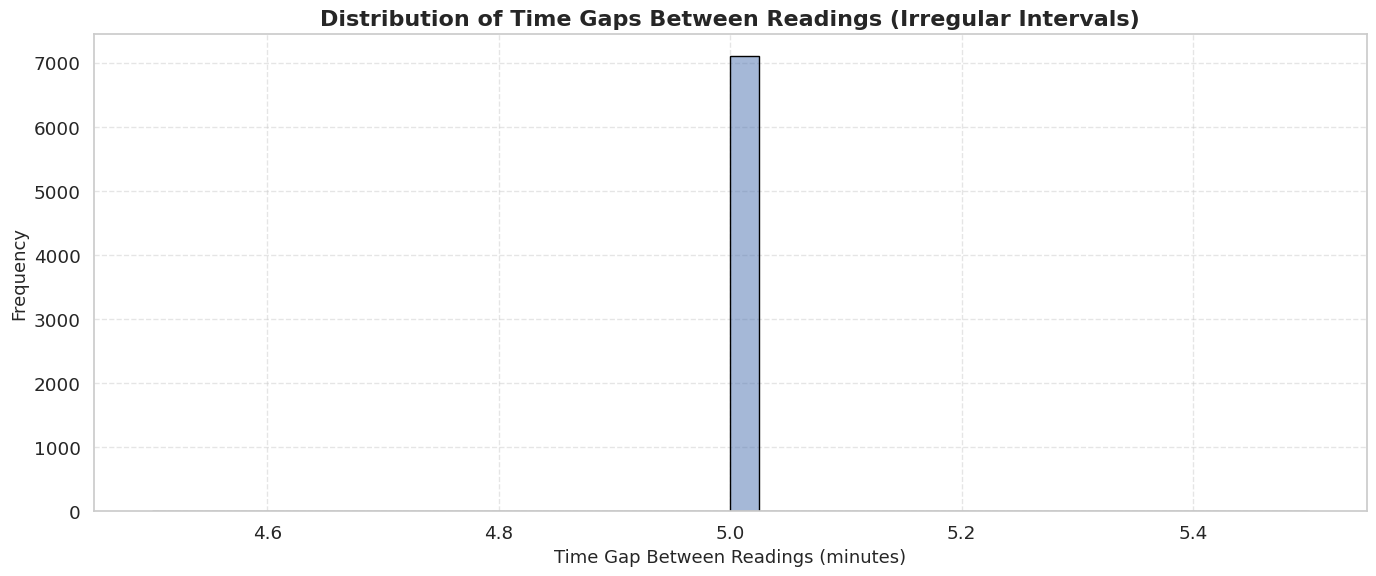

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern, clean style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the histogram
plt.figure(figsize=(14, 6))
hist = sns.histplot(
    data=Sickbay['time_diff'].dropna(),
    bins=40,
    kde=True,
    color="#4C72B0",
    edgecolor='black'
)

# Add labels and title
plt.title("Distribution of Time Gaps Between Readings (Irregular Intervals)", fontsize=16, fontweight='bold')
plt.xlabel("Time Gap Between Readings (minutes)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

# Add gridlines and tight layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


# Step 4: Find Irregular Intervals

# Assume that the ideal interval is 1 minute or 5 minutes

In [197]:
# Example: Ideal time difference = 1 minute
irregular_intervals = Sickbay[Sickbay['time_diff'] != 1]
print(f"Irregular intervals found: {len(irregular_intervals)}")
irregular_intervals[['patient_id', 'timestamp_min', 'time_diff']].head()


Irregular intervals found: 7200


,patient_id,timestamp_min,time_diff
0,1,0,NaN
1,1,5,5.0
2,1,10,5.0
3,1,15,5.0
4,1,20,5.0


In [198]:
irregular_intervals.isnull().sum()

,0
patient_id,0
timestamp_min,0
heart_rate,0
bp_sys,0
bp_dia,0
spo2,0
temperature,0
wbc,0
lactate,0
sepsis_label,0


In [199]:
irregular_intervals = Sickbay[(Sickbay['time_diff'].notna()) & (Sickbay['time_diff'] != 1)]


In [200]:
irregular_intervals.isnull().sum()

,0
patient_id,0
timestamp_min,0
heart_rate,0
bp_sys,0
bp_dia,0
spo2,0
temperature,0
wbc,0
lactate,0
sepsis_label,0


In [201]:
irregular_intervals.isnull()

,patient_id,timestamp_min,heart_rate,bp_sys,bp_dia,spo2,temperature,wbc,lactate,sepsis_label,ventilation,medication_administered,time_diff
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,False,False,False,False,False,False,False,False,False,False,False,False,False
7196,False,False,False,False,False,False,False,False,False,False,False,False,False
7197,False,False,False,False,False,False,False,False,False,False,False,False,False
7198,False,False,False,False,False,False,False,False,False,False,False,False,False


In [202]:
irregular_intervals.to_csv("irregular_time_intervals.csv", index=False)


In [203]:
Sickbay.columns# get the columns

Index(['patient_id', 'timestamp_min', 'heart_rate', 'bp_sys', 'bp_dia', 'spo2',
       'temperature', 'wbc', 'lactate', 'sepsis_label', 'ventilation',
       'medication_administered', 'time_diff'],
      dtype='object')

In [204]:
for col in Sickbay.columns:
    print(f"{col}: {Sickbay[col].nunique()} unique values")


patient_id: 100 unique values
timestamp_min: 72 unique values
heart_rate: 6840 unique values
bp_sys: 6840 unique values
bp_dia: 7200 unique values
spo2: 6840 unique values
temperature: 6840 unique values
wbc: 7200 unique values
lactate: 7200 unique values
sepsis_label: 2 unique values
ventilation: 2 unique values
medication_administered: 2 unique values
time_diff: 1 unique values


In [205]:
numeric_cols = Sickbay.select_dtypes(include=['number']).columns.tolist()
print("Numeric Columns:", numeric_cols)


Numeric Columns: ['patient_id', 'timestamp_min', 'heart_rate', 'bp_sys', 'bp_dia', 'spo2', 'temperature', 'wbc', 'lactate', 'sepsis_label', 'ventilation', 'medication_administered', 'time_diff']


In [206]:
categorical_cols = Sickbay.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_cols)


Categorical Columns: []


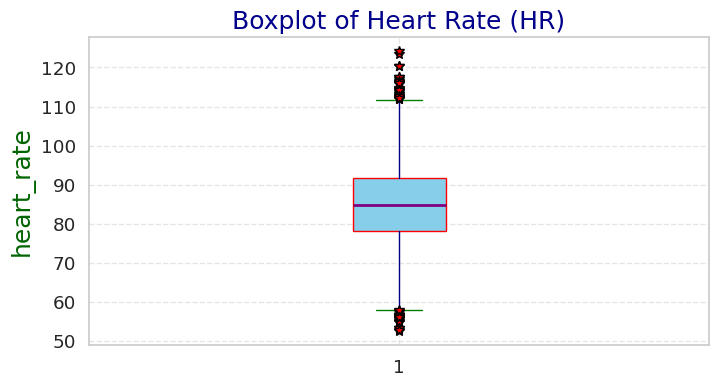

In [207]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.boxplot(
    Sickbay['heart_rate'].dropna(),
    patch_artist=True,  # Fill box with color
    boxprops=dict(facecolor='skyblue', color='Red'),
    capprops=dict(color='green'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(markerfacecolor='red', marker='*', markersize=7, linestyle='none'),
    medianprops=dict(color='purple', linewidth=2)
)
plt.title("Boxplot of Heart Rate (HR)", fontsize=18, color='darkblue')
plt.ylabel("heart_rate", fontsize=18, color='darkgreen')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [208]:
Q1 = Sickbay['heart_rate'].quantile(0.25)
Q3 = Sickbay['heart_rate'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = Sickbay[(Sickbay['heart_rate'] < lower_bound) | (Sickbay['heart_rate'] > upper_bound)]
print("Number of outliers in heart_rate:", outliers.shape[0])


Number of outliers in heart_rate: 53


In [209]:
df_no_outliers = Sickbay[(Sickbay['heart_rate'] >= lower_bound) & (Sickbay['heart_rate'] <= upper_bound)]


In [210]:
median_hr = Sickbay['heart_rate'].median()
Sickbay['heart_rate'] = Sickbay['heart_rate'].apply(lambda x: median_hr if x < lower_bound or x > upper_bound else x)


In [211]:
import numpy as np

Sickbay['heart_rate'] = Sickbay['heart_rate'].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
Sickbay['heart_rate'] = Sickbay['heart_rate'].interpolate()


In [212]:
Sickbay.columns

Index(['patient_id', 'timestamp_min', 'heart_rate', 'bp_sys', 'bp_dia', 'spo2',
       'temperature', 'wbc', 'lactate', 'sepsis_label', 'ventilation',
       'medication_administered', 'time_diff'],
      dtype='object')

In [213]:
numeric_cols = ['heart_rate','bp_sys','bp_dia','spo2','temperature','wbc','lactate','sepsis_label', 'ventilation',
       'medication_administered']

for col in numeric_cols:
    Q1 = Sickbay[col].quantile(0.25)
    Q3 = Sickbay[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    Sickbay[col] = Sickbay[col].apply(lambda x: np.nan if x < lower or x > upper else x)
    Sickbay[col] = Sickbay[col].interpolate()


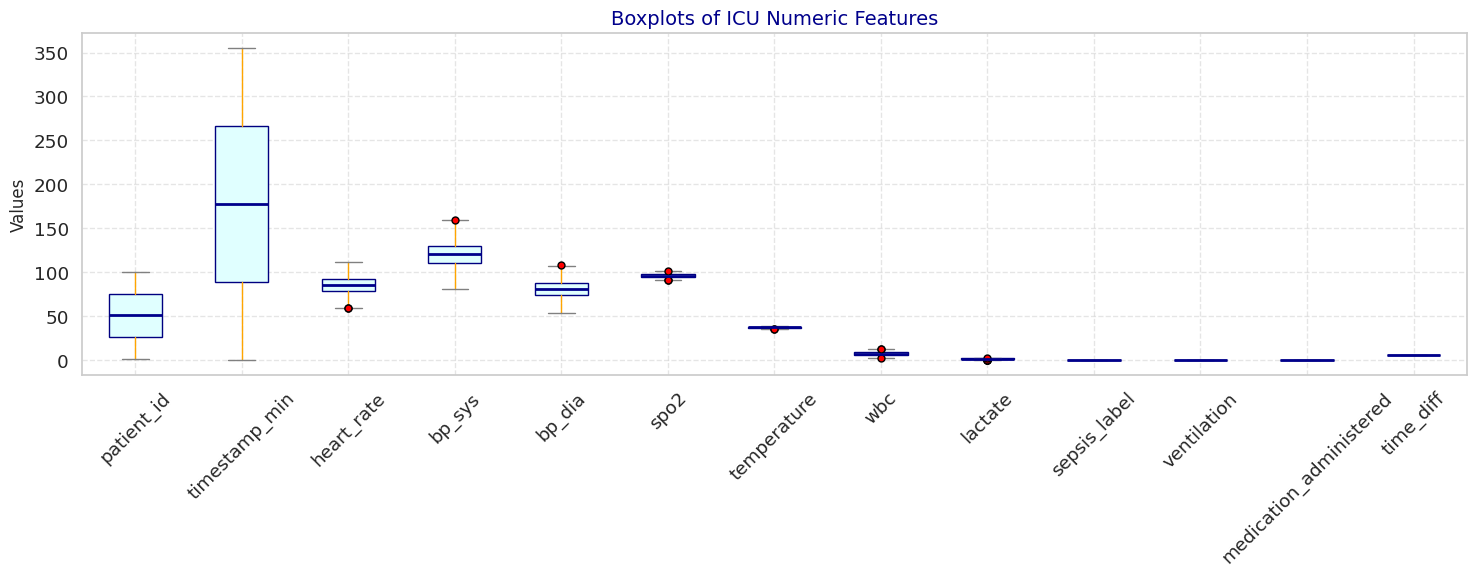

In [214]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Identify numeric columns
numeric_cols = Sickbay.select_dtypes(include='number').columns.tolist()

# Step 2: Plot boxplots
plt.figure(figsize=(15, 6))
box = plt.boxplot(
    [Sickbay[col].dropna() for col in numeric_cols],
    patch_artist=True,  # Fill box with color
    labels=numeric_cols,
    boxprops=dict(facecolor='lightcyan', color='navy'),
    capprops=dict(color='gray'),
    whiskerprops=dict(color='orange'),
    flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'),
    medianprops=dict(color='darkblue', linewidth=2)
)

# Title and Labels
plt.title("Boxplots of ICU Numeric Features", fontsize=14, color='darkblue')
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#Outliers here refer to abnormal values that occur due to temporary disconnections in the system — for example, if the machine or sensor was temporarily offline.

In [215]:
def remove_outliers_iqr(Sickbay, columns):
    for col in columns:
        if Sickbay[col].dtype != 'object':  # Sirf numeric columns ke liye
            Q1 = Sickbay[col].quantile(0.25)
            Q3 = Sickbay[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            Sickbay = Sickbay[(Sickbay[col] >= lower_bound) & (Sickbay[col] <= upper_bound)]
    return Sickbay


In [216]:
# Sirf numeric columns select karo (excluding IDs, labels if needed)
numeric_cols = ['heart_rate', 'bp_sys', 'bp_dia', 'spo2', 'temperature', 'wbc', 'lactate']

Sickbay_cleaned = remove_outliers_iqr(Sickbay, numeric_cols)


In [217]:
import seaborn as sns

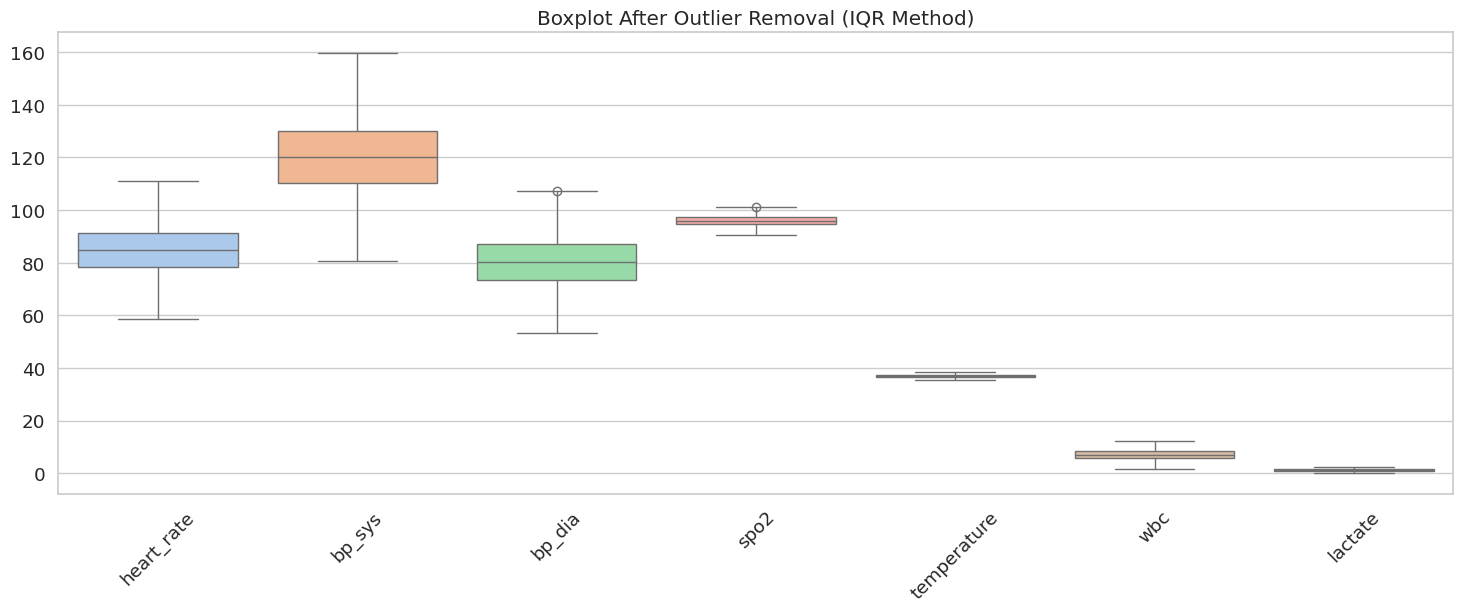

In [218]:
plt.figure(figsize=(18,6))
sns.boxplot(data=Sickbay_cleaned[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplot After Outlier Removal (IQR Method)")
plt.show()


In [219]:
print(f"Original rows: {Sickbay.shape[0]}")
print(f"Cleaned rows: {Sickbay_cleaned.shape[0]}")


Original rows: 7200
Cleaned rows: 7184


In [220]:
# Create time_diff column
Sickbay['time_diff'] = Sickbay['timestamp_min'].diff()

# Fill NaN with median
Sickbay['time_diff'] = Sickbay['time_diff'].fillna(Sickbay['time_diff'].median())

In [221]:
Sickbay.isnull().sum()

,0
patient_id,0
timestamp_min,0
heart_rate,0
bp_sys,0
bp_dia,0
spo2,0
temperature,0
wbc,0
lactate,0
sepsis_label,0


In [222]:
Sickbay_cleaned.to_csv('Cleaned_data.csv', index=False)